In [41]:
import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

def read_DICOM(dir_path):
    'Read DICOM image from directory'
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( dir_path )
    if len(dicom_names) > 0:
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        return image
    else:
        return None

def read_DICOMs(rootdir):
    'Read all DICOMs in a directory tree'
    images = list()
    for root, subFolders, files in os.walk(rootdir):
        for subf in subFolders:
            try:
                dir_path = os.path.join(root, subf)
                image = read_DICOM(dir_path=dir_path)
                # if image:
                #    print("Read {}".format(dir_path))
            except:
                pass
                # print("Error reading {}".format(dir_path))
            if image:
                if image.GetSize()[2] > 1:
                    # im_array = sitk.GetArrayFromImage(image)
                    images.append(image)
    return images

def show_slice(im, axis=1, fract=0.5):
    'Show slice along axis at fraction of slice'
    idx = int(im.shape[axis]*fract)
    if axis == 0:
        im_slice = im[idx, :, :]
    elif axis == 1:
        im_slice = im[:, idx, :]
    elif axis == 2:
        im_slice = im[:, :, idx]
    else:
        im_slice = im[idx, :, :]
        
    plt.imshow(im_slice, cmap='gray')
    

In [2]:
kich_kidney = read_DICOMs(rootdir='/home/ktdiedrich/Documents/localData/RadiologyImages/TCGAkidney/TCGA-KICH')
print("KICH_kidney N={}".format(len(kich_kidney)))

KICH_kidney N=90


In [3]:
prostate = read_DICOMs(rootdir='/home/ktdiedrich/Documents/localData/RadiologyImages/ProstateFusedMRIPathology')
print("Prostate N={}".format(len(prostate)))

Prostate N=203


In [4]:
label_name = dict()
label_name[0] = "KICH Kidney"
label_name[1] = "Prostate"
kich_labels = [0] * len(kich_kidney) 
prostate_labels = [1] * len(prostate)
labels = kich_labels + prostate_labels
print("kich_labels={}, prostate_labels={}, labels={}".format(len(kich_labels), len(prostate_labels),
                                                            len(labels)))

kich_labels=90, prostate_labels=203, labels=293


kich_kidney[5] shape=(512, 512, 301)
prostate[3] shape=(256, 256, 22)


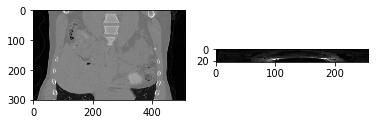

In [5]:
print("kich_kidney[5] shape={}".format(kich_kidney[5].GetSize()))
print("prostate[3] shape={}".format(prostate[3].GetSize()))
plt.subplot(1, 2, 1)
show_slice(im=sitk.GetArrayFromImage(kich_kidney[5]), axis=1)
plt.subplot(1, 2, 2)
show_slice(im=sitk.GetArrayFromImage(prostate[3]), axis=1)

In [82]:
kich_sizes = [x.GetSize() for x in kich_kidney]
prostate_sizes = [x.GetSize() for x in prostate]
print("kich_sizes: {}".format(kich_sizes[0:10]))
print("prostate_sizes: {}".format(prostate_sizes[0:10]))

kich_sizes: [(512, 512, 81), (512, 512, 67), (512, 512, 67), (512, 512, 138), (512, 512, 51), (512, 512, 301), (512, 512, 251), (512, 512, 327), (512, 512, 61), (512, 512, 89)]
prostate_sizes: [(512, 512, 350), (512, 512, 176), (128, 228, 32), (256, 256, 22), (512, 512, 26), (256, 256, 26), (256, 256, 52), (256, 256, 26), (256, 256, 26), (256, 256, 52)]


In [93]:
kich_median = [int(np.median([x.GetSize()[0] for x in kich_kidney])),
              int(np.median([x.GetSize()[1] for x in kich_kidney])),
              int(np.median([x.GetSize()[2] for x in kich_kidney]))]
prostate_median = [int(np.median([x.GetSize()[0] for x in prostate])),
                  int(np.median([x.GetSize()[1] for x in prostate])),
                  int(np.median([x.GetSize()[2] for x in prostate]))]
print("kich_median={}, prostate_median={}".format(kich_median, prostate_median))
# ref_image = prostate[200]
ref_image = prostate[6]
print("ref_image size={}".format(ref_image.GetSize()))

kich_median=[512, 512, 67], prostate_median=[256, 256, 33]
ref_image size=(256, 256, 52)


In [123]:
def resample_image(itk_image, out_size=[64, 64, 16]):
    """Resample images to new size
    based on https://www.programcreek.com/python/example/96383/SimpleITK.sitkNearestNeighbor 
    """
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_spacing = [
        original_spacing[0] * (original_size[0]/out_size[0]),
        original_spacing[1] * (original_size[1]/out_size[1]),
        original_spacing[2] * (original_size[2]/out_size[2])
    ]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    # resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(itk_image)

size=(512, 512, 327) mean=-5.83e+02 sd=4.9e+02 -> size=(16, 64, 64) mean=-5.82e+02 sd=4.91e+02


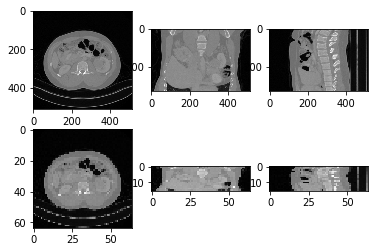

In [122]:
resamp_im = kich_kidney[7]
resamp_ar = sitk.GetArrayFromImage(resamp_im)
resampled_im = resample_image(resamp_im)
resampled = sitk.GetArrayFromImage(resampled_im)
print("size={} mean={:.3} sd={:.3} -> size={} mean={:.3} sd={:.3}".format(resamp_im.GetSize(), 
    np.mean(resamp_ar), np.std(resamp_ar), resampled.shape, np.mean(resampled), np.std(resampled) ) )
fract = 0.5
plt.subplot(2, 3, 1)
show_slice(resamp_ar, axis=0, fract=fract)
plt.subplot(2, 3, 2)
show_slice(resamp_ar, axis=1, fract=fract)
plt.subplot(2, 3, 3)
show_slice(resamp_ar, axis=2, fract=fract)
plt.subplot(2, 3, 4)
show_slice(resampled, axis=0, fract=fract)
plt.subplot(2, 3, 5)
show_slice(resampled, axis=1, fract=fract)
plt.subplot(2, 3, 6)
show_slice(resampled, axis=2, fract=fract)

In [127]:
import itertools
arrays = list()
failed_idx = list()
idx = 0
for image in itertools.chain(kich_kidney, prostate):
    try:
        resampled = resample_image(image)
        arrays.append(sitk.GetArrayFromImage(resampled))
    except RuntimeError as rune:
        failed_idx.append(idx)
        print(rune)
    finally:
        idx+=1
    

failed: []


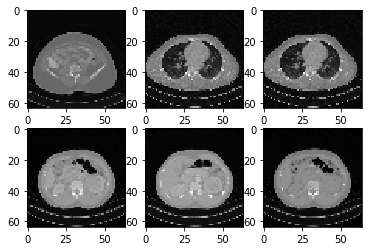

In [129]:
print("failed: {}".format(failed_idx))
# print([ar.shape for ar in arrays])
for idx in range(0, 6):
    plt.subplot(2, 3, idx+1)
    show_slice(arrays[idx], axis=0)

<class 'numpy.ndarray'>
<class 'tuple'> <class 'tuple'>
arrays=293, labels=293, label_cats=(293, 2)
(293, 16, 64, 64)
(1, 1, 1, 0, 0, 1, 0, 1, 1)


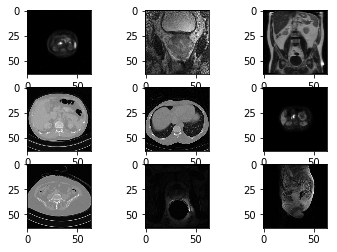

In [158]:
print(type(arrays[0]))
print("{} {}".format(type(arrays), type(labels)))
import random
array_label = list(zip(arrays, labels))
random.shuffle(array_label)
arrays, labels = zip(*array_label)
label_cats = to_categorical(labels)
print("arrays={}, labels={}, label_cats={}".format(len(arrays), len(labels), label_cats.shape))
np_arrays = np.array(arrays)
print(np_arrays.shape)
a = 0; b = 9
plot_idx = 1
print(labels[a:b]) 
for idx in range(a, b):
    plt.subplot(3, 3, plot_idx)
    show_slice(np_arrays[idx], axis=0)
    plot_idx+=1

In [13]:
# monitor GPU with nvidia-smi stats 